# Multi-view reconstruction and Meshing

## 1. Prerequisites

### 1.1 Load data

In [1]:
from openalea.phenomenal.data_access.plant_1 import (
    plant_1_images,
    plant_1_images_binarize,
    plant_1_calibration_camera_side,
    plant_1_calibration_camera_top)

images_raw = plant_1_images()
images_bin = plant_1_images_binarize()
calibration_side = plant_1_calibration_camera_side()
calibration_top = plant_1_calibration_camera_top()

<IPython.core.display.Javascript object>


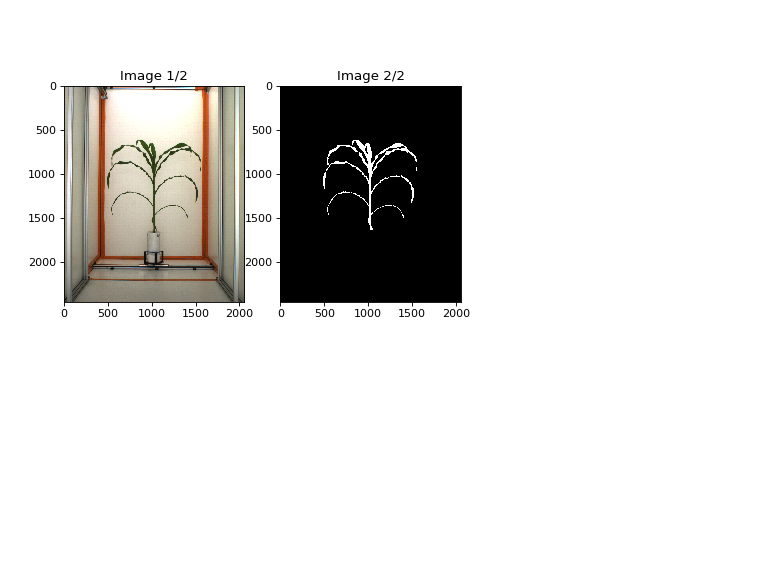

In [2]:
%matplotlib notebook

from openalea.phenomenal.display.image import show_images

angle = 120
show_images([images_raw['side'][angle], images_bin[angle]])

## 2. Multi-view reconstruction

### 2.1 Associate images and projection function

In [3]:
from openalea.phenomenal.data_structure import ImageView

refs_angle_list = [120]

# Select images
image_views = list()
for angle in range(0, 360, 30):
    projection = calibration_side.get_projection(angle)
    
    ref = False
    if angle in refs_angle_list:
        ref = True
    
    image_views.append(ImageView(images_bin[angle], projection, inclusive=False, ref=ref))

projection = calibration_top.get_projection(0)
image_views.append(ImageView(images_bin[-1], projection, inclusive=True))

### 2.2 Do multi-view reconstruction

In [4]:
from openalea.phenomenal.data_structure import VoxelGrid
from openalea.phenomenal.multi_view_reconstruction import reconstruction_3d

voxels_size = 4
error_tolerance = 1

vg = reconstruction_3d(image_views, 
                       voxels_size=voxels_size, 
                       error_tolerance=error_tolerance, 
                       verbose=True)

Iteration 1 / 10 : 8
Iteration 2 / 10 : 64
Iteration 3 / 10 : 512
Iteration 4 / 10 : 4096
Iteration 5 / 10 : 400
Iteration 6 / 10 : 1392
Iteration 7 / 10 : 4216
Iteration 8 / 10 : 13776
Iteration 9 / 10 : 55560
Iteration 10 / 10 : 253656


### 2.4 Viewing

In [10]:
from openalea.phenomenal.display.notebook import show_voxel_grid

show_voxel_grid(vg, size_ratio=0.5)

VBox(children=(Figure(anglex=1.5707963267948966, camera_center=[0.0, 0.0, 0.0], height=800, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color=array('green',
      dtype='|S5'), color_selected=array('white',
      dtype='|S5'), geo=u'box', size=array(0.5), size_selected=array(2.6), x=array([ 486.,  490.,  494., ...,  454.,  454.,  462.]), y=array([ 382.,  378.,  374., ...,  318.,  326.,  326.]), z=array([ 394.,  394.,  390., ...,  150.,  142.,  134.]))], style={'box': {'visible': False}, 'axes': {'color': 'black', 'visible': False, 'ticklabel': {'color': 'black'}, 'label': {'color': 'black'}}, 'background-color': 'white'}, tf=None, width=800, xlim=[-470.0, 518.0], ylim=[-446.0, 382.0], zlim=[-442.0, 746.0]),))

# 3.Meshing

In [11]:
from openalea.phenomenal.mesh import meshing

image_3d = vg.to_image_3d()

vertices, faces = meshing(image_3d,
                          reduction=0.99,
                          smoothing_iteration=10,
                          verbose=True)

print("Number of vertices : {nb_vertices}".format(nb_vertices=len(vertices)))
print("Number of faces : {nb_faces}".format(nb_faces=len(faces)))

Marching cubes : 
	Iso value :1.0

	There are 64048 points.
	There are 129473 polygons.
Smoothing : 
	Feature angle :120.0
	Number of iteration :10
	Pass band : 0.01

Decimation : 
	Reduction (percentage) :0.99

	Before decimation
	-----------------
	There are 64048 points.
	There are 129473 polygons.

	After decimation
	-----------------
	There are 0.99 points.
	There are 64048 polygons.
Number of vertices : 657
Number of faces : 1293


In [12]:
from openalea.phenomenal.display.notebook import show_mesh

show_mesh(vertices, faces)

VBox(children=(Figure(anglex=1.5707963267948966, camera_center=[0.0, 0.0, 0.0], height=800, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('green',
      dtype='|S5'), texture=None, triangles=array([[  0,   1,   2],
       [  3,   2,   1],
       [  0,   4,   1],
       ..., 
       [652, 650, 653],
       [654, 652, 656],
       [652, 653, 656]], dtype=uint32), x=array([  3.33301392e+01,   9.28366089e+00,   3.09027100e+00,
         1.48362427e+01,   4.35040283e+01,   2.55494080e+01,
        -9.09027100e-01,   1.00384705e+02,   1.00200562e+02,
         1.37714355e+02,   4.18459778e+01,   7.37640381e-01,
         2.36936646e+01,   3.81753540e+00,   2.84991150e+01,
        -1.86293976e+02,  -1.83589050e+02,  -2.06913208e+02,
        -1.58235443e+02,  -2.39899292e+01,   2.08441162e+01,
        -1.40673004e+02,  -6.13891602e-01,  -6.60297241e+01,
        -5.73004761e+01,  -1.10778198e+02,  -8.90691833e+01,
         1.65335693e+01,   1.50673523e+01,   3.23537903e+01,
         7.34266357e+01,   6.97526855e+01,   4.84209595e+01,
         3.71661377e+00,   3.38558411e+02,   3.17155029e+02,
         3.32624634e+02,   2.51929321e+01,   6.58377075e+00,
         2.91412964e+01,   2.96992004e+02,   2.79292603e+02,
         9.17243042e+01,   9.93981934e+01,   1.44642578e+02,
         1.72730042e+02,   2.90474426e+02,   2.55263367e+02,
         1.48074341e+02,  -2.92092896e+00,   1.74994263e+02,
         1.67631531e+01,   2.25749268e+02,  -1.74649963e+01,
         2.60200500e+01,   2.66346497e+02,   2.57186890e+01,
         2.10697388e+02,   1.96735901e+02,  -4.03110352e+01,
         8.03497314e+00,  -1.46773987e+01,   8.20727539e+00,
        -7.13726196e+01,  -3.14795227e+01,  -3.48079002e+02,
        -3.41754211e+02,  -3.22896484e+02,   4.69757507e+02,
         4.55319824e+02,   4.61065247e+02,  -3.44358063e+02,
         2.58209839e+01,  -7.75637512e+01,   4.58911194e+02,
         4.54161499e+02,  -5.83523560e+01,  -1.08869446e+02,
         4.57083130e+02,   4.77764282e+02,  -3.19355240e+02,
         4.77640320e+02,  -7.56485291e+01,   2.00970459e+00,
        -2.90433472e+02,  -9.32506714e+01,   4.55014160e+02,
         4.70252930e+02,  -1.57140045e+02,   1.07189941e+01,
         3.98501587e+01,  -2.85978973e+02,  -1.56142853e+02,
         1.06347961e+01,  -2.48858231e+02,   3.63135681e+01,
        -2.58119003e+02,  -2.56470413e+02,  -1.14901794e+02,
        -1.83832092e+02,  -2.51886856e+02,   2.98128662e+01,
        -1.71570984e+02,  -2.21625061e+02,  -1.46942535e+02,
         3.34961243e+01,  -1.91547791e+02,  -2.03247223e+02,
         6.34996338e+01,  -2.48082870e+02,   2.20262146e+01,
        -2.23407593e+02,  -1.89101318e+02,  -2.33190414e+02,
         5.29755249e+01,   4.67456665e+01,   4.66224548e+02,
         4.98699951e+00,   8.26743164e+01,   3.14189148e+01,
         1.02655579e+02,   6.25200806e+01,   2.12923889e+01,
         1.34683228e+01,   4.47987854e+02,   8.35098267e+01,
         1.04984680e+02,  -4.21646408e+02,  -4.26124012e+02,
        -4.42756536e+02,  -4.23791275e+02,   4.60640320e+02,
         4.36805664e+02,   7.17487183e+01,   2.88755493e+01,
         4.40231628e+02,   3.17779541e+01,   1.40561096e+02,
         1.19597961e+02,  -4.30448341e+02,  -4.18677864e+02,
         3.74970703e+01,   1.20556824e+02,  -4.46150528e+02,
        -8.91229248e+00,   4.30403564e+02,  -5.25619507e+00,
        -4.31419582e+02,   1.60961975e+02,   1.53736450e+02,
         4.03309326e+02,   1.81783447e+01,  -4.35964321e+02,
         1.36035706e+02,   1.87083740e+02,   1.53832336e+02,
        -4.24031746e+02,  -4.34371758e+02,  -1.09872131e+01,
         3.99309143e+02,  -4.43757563e+02,  -2.49086304e+01,
         2.32390442e+01,  -3.66813049e+01,   4.24689697e+02,
         1.72509705e+02,   2.85878601e+01,   1.93954041e+02,
        -4.25250771e+02,  -4.35500088e+02,  